<a href="https://colab.research.google.com/github/Rajnandini17/Deep-Learning-projects/blob/main/Pneumonia_detection_from_chest_Xrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GETTING THE DATASET AND PARSING IT

In [1]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2023-09-17 18:45:56--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2023-09-17 18:45:57--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf59d5a483d72dbbba30a48d9a7.dl.dropboxusercontent.com/cd/0/inline/CD6a0RAViBjAzoawkMZSlkB_N01LaGgbOGA_PkbdmHdKaB2JlMYopVKRKBGBqzTdeh5uRFy1OFxxifblyPguwYco1Aw4tWFpoZBvPkmgajN1IqvM7_kIjEvIguaj1Gek-ssq8WqdnixG3Ws2i3ttCBR1/file# [following]
--2023-09-17 18:45:57--  https://ucf59d5a483d72dbbba30a48d9a7.dl.dropboxusercontent.com/cd/0/inline/CD6a0RAViBjAzoawkMZSlkB_N01LaGgbOGA_PkbdmHdKaB2JlMYopVKRKBGBqzTdeh5uRFy1OFxxifblyPguwYco1Aw4tWFpoZBvPkm

In [2]:
!unzip -q "archive.zip"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [4]:
#Creating pathlib PATH objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [5]:
#collecting all paths inside 'normal' and 'pneumonia' folders of the above path
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

#output is a generator object
print(train_image_paths)

<generator object Path.glob at 0x7fa7b0730970>


In [6]:
#convert generator objects to list of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

#output is 'PoxisPath' object
print(train_image_paths[:3])

[PosixPath('chest_xray/train/PNEUMONIA/person1488_virus_2585.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person1389_virus_2387.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person1385_bacteria_3524.jpeg')]


In [7]:
#collecting length for training and validation sets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [8]:
# Every Image has Label in its path , so lets slice it
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[str(path).split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[1, 1, 1]


## TRANSFORMATION OF IMAGE DATA

In [9]:
BATCH_SIZE = 32

# function for transformation
def load_and_transform(image, label, train = True):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224, 224], method = "nearest")
  if train:
    image = tf.image.random_flip_left_right(image)
  return image, label

In [10]:
# function to create a tensorflow object
def get_dataset(paths, labels, train = True):

  image_paths = [str(path) for path in paths]

  image_paths = tf.convert_to_tensor(image_paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image, label : load_and_transform(image, label, train))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)

  return dataset

In [11]:
#creating train dataset object & verifying it
%time train_dataset = get_dataset(train_image_paths, train_labels)

CPU times: user 747 ms, sys: 574 ms, total: 1.32 s
Wall time: 3.38 s


In [12]:
image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


PNEUMONIA


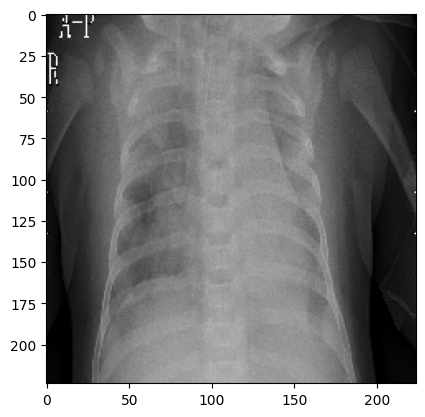

In [13]:
#viewing sample train image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [14]:
%time val_dataset = get_dataset(val_image_paths, val_labels, train = False)
image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 24.1 ms, sys: 0 ns, total: 24.1 ms
Wall time: 35.3 ms
(32, 224, 224, 3)
(32,)


##BUILDING TENSORFLOW MODEL

In [16]:
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape = (224, 224, 3),
    include_top = False
)
model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 23521409 (89.73 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [17]:
# Compiling the model using Optimizer, loss, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)


In [18]:
#defining the callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose=1, save_best_only = True, save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience = 4)

In [20]:
# training the model
history = model.fit (
    train_dataset,
    steps_per_epoch = train_dataset_length//BATCH_SIZE,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9440 - precision: 0.9633 - recall: 0.9675
Epoch 1: val_loss improved from inf to 1.29297, saving model to best_weights.h5
163/163 [==============================] - 131s 485ms/step - loss: 0.1572 - accuracy: 0.9440 - precision: 0.9633 - recall: 0.9675 - val_loss: 1.2930 - val_accuracy: 0.7270 - val_precision: 0.9139 - val_recall: 0.6305
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9530 - precision: 0.9702 - recall: 0.9664
Epoch 2: val_loss improved from 1.29297 to 1.03279, saving model to best_weights.h5
163/163 [==============================] - 78s 478ms/step - loss: 0.1180 - accuracy: 0.9530 - precision: 0.9702 - recall: 0.9664 - val_loss: 1.0328 - val_accuracy: 0.6809 - val_precision: 0.6554 - val_recall: 1.0000
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9695 - precision: 0.9791 - recall: 0.9803
Epoch 3

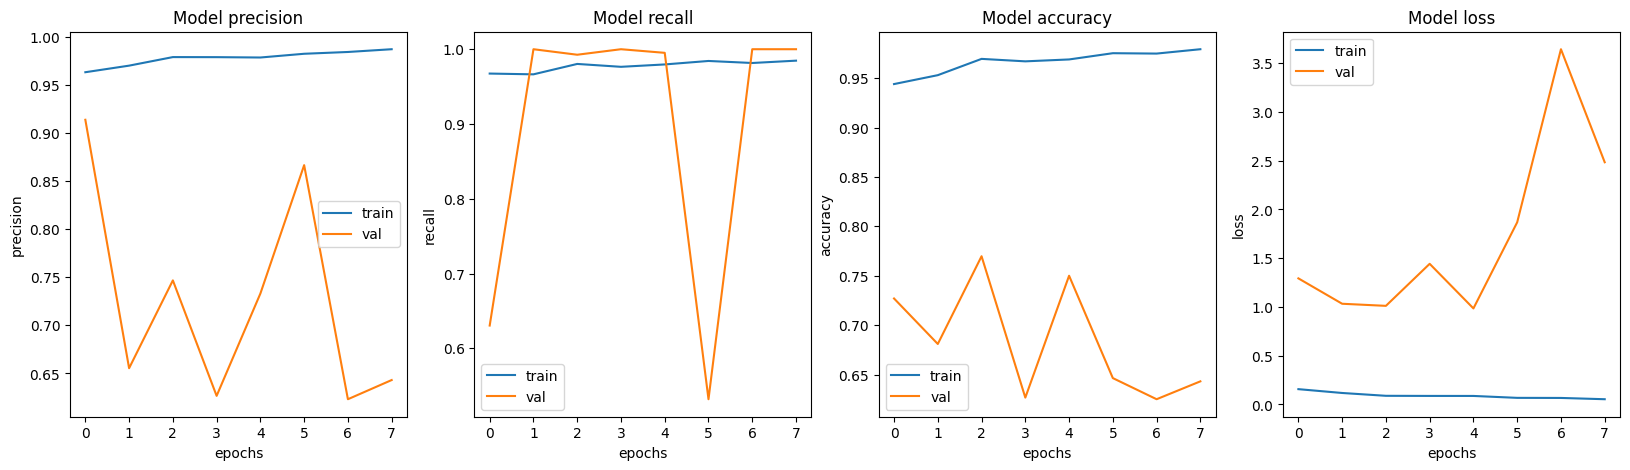

In [21]:
#interpreting the metrics
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_' + met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

##SAVING THE TRAINED MODEL

In [22]:
model.load_weights("best_weights.h5")
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
#loading the model
loaded_model = tf.keras.models.load_model("model.h5")

##USING THE MODEL ON TEST DATA

In [24]:
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x), test_image_paths))
test_labels = list(map(lambda x : get_label(x), test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224, 224], method = "nearest")
  return image, label

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)


In [25]:
#verify test dataset object
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


PNEUMONIA


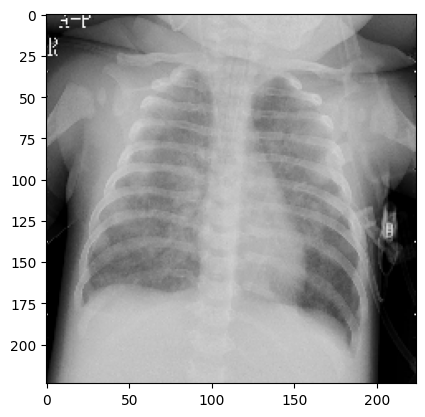

In [26]:
#view a sample validation image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [27]:
#evaluating the model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)
print("Testing acc:", acc)
print("testing prec:", prec)
print("testing recall:", rec)

1/1 [==============================] - 2s 2s/step - loss: 1.2215 - accuracy: 0.6250 - precision: 0.5714 - recall: 1.0000
Testing acc: 0.625
testing prec: 0.5714285969734192
testing recall: 1.0
